In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
#Loading the dataset
dataset, info = tfds.load('glue/sst2', with_info = True)

In [3]:
#Getting the Data
print(dataset.keys())
print(dataset.items())
print(dataset.values())

dict_keys(['train', 'validation', 'test'])
dict_items([('train', <PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>), ('validation', <PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>), ('test', <PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>)])
dict_values([<PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>, <PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>, <PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>])


In [4]:
#Getting the info
print(info.description)
print(info.features)
print(info.features.items())
data = info.features
print(info.features['label'].num_classes)
print(data['label'].names)

GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.
FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
dict_items([('sentence', Text(shape=(), dtype=tf.string)), ('label', ClassLabel(shape=(), dtype=tf.int64, num_classes=2)), ('idx', Tensor(shape=(), dtype=tf.int32))])
2
['negative', 'positive']


In [5]:
#Getting the training and testing dataset
train_data, valid_data = dataset['train'], dataset['validation']
print(train_data)

<PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>


In [6]:
#Print some examples from the entries
for i in train_data.take(10):
    sentence, label = i['sentence'], i['label']
    print("Sentences: ",str(sentence.numpy()))
    print("Label: ",label.numpy())
    print("\n")

Sentences:  b'for the uninitiated plays better on video with the sound '
Label:  0


Sentences:  b'like a giant commercial for universal studios , where much of the action takes place '
Label:  0


Sentences:  b'company once again dazzle and delight us '
Label:  1


Sentences:  b"'s no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke "
Label:  1


Sentences:  b', this cross-cultural soap opera is painfully formulaic and stilted . '
Label:  0


Sentences:  b", the film is n't nearly as downbeat as it sounds , but strikes a tone that 's alternately melancholic , hopeful and strangely funny . "
Label:  1


Sentences:  b'only masochistic moviegoers need apply . '
Label:  0


Sentences:  b'convince almost everyone that it was put on the screen , just for them '
Label:  1


Sentences:  b"like the english patient and the unbearable lightness of being , the hours is one of those reputedly `` unfilmable '' novels that

In [7]:
#Getting the Training and Validation Data from the dataset
training_sentences = []
training_labels = []

validation_sentences = []
validation_labels = []

for item in train_data.take(10000):
    review, label = item["sentence"], item["label"]
    training_sentences.append(str(review.numpy()))
    training_labels.append(label.numpy())

#Printing the number of training_sentences dataset
print("No of Sentences: ", len(training_sentences))

#Printing Some Examples
print("No of Examples: ",training_sentences[0:2])

# Get the validation data
# there's only about 800 items, so take them all
for sentence in valid_data.take(-1):  #Here Valid_data.take(-1) , "-1" is used to take all items
    v_sentences, v_labels = sentence['sentence'], sentence['label']
    validation_sentences.append(str(v_sentences.numpy()))
    validation_labels.append(v_labels.numpy())
    
print("The Total no of Validation Data: ",len(validation_sentences))

#Printing Some Validation Sentences
print(validation_sentences[0:2])

No of Sentences:  10000
No of Examples:  ["b'for the uninitiated plays better on video with the sound '", "b'like a giant commercial for universal studios , where much of the action takes place '"]
The Total no of Validation Data:  872
["b'a valueless kiddie paean to pro basketball underwritten by the nba . '", 'b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade \'\' covers the same period as kaufmann \'s `` quills \'\' with more unsettlingly realistic results . "']


# Pad The Sequences

In [8]:
vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
#Padding the sequence
training_sequence = tokenizer.texts_to_sequences(training_sentences)
padded_training = tf.keras.preprocessing.sequence.pad_sequences(training_sequence, maxlen=max_length,padding=pad_type,truncating=trunc_type)

valid_sequence = tokenizer.texts_to_sequences(validation_sentences)
padded_valid = tf.keras.preprocessing.sequence.pad_sequences(valid_sequence, maxlen=max_length, padding=pad_type, truncating=trunc_type)

#Converting labels into arrays
train_label_array = np.array(training_labels)
valid_label_array = np.array(validation_labels)

# Create the model using an Embedding

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(tf.keras.layers.GlobalAvgPool1D())
model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics=['mae', 'accuracy'])

In [10]:
#Fitting the model
history = model.fit(padded_training,train_label_array, epochs = 100, validation_data=(padded_valid, valid_label_array))

Epoch 1/100


C:\Users\Mustafa Hasnain\anaconda3\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


313/313 [==============================] - 1s 3ms/step - loss: 0.6848 - mae: 0.4932 - accuracy: 0.5506 - val_loss: 0.6894 - val_mae: 0.4961 - val_accuracy: 0.5115
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 0.6742 - mae: 0.4860 - accuracy: 0.5669 - val_loss: 0.6739 - val_mae: 0.4889 - val_accuracy: 0.6021
Epoch 3/100
313/313 [==============================] - 1s 2ms/step - loss: 0.6553 - mae: 0.4759 - accuracy: 0.6151 - val_loss: 0.6500 - val_mae: 0.4733 - val_accuracy: 0.6365
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.6267 - mae: 0.4587 - accuracy: 0.6656 - val_loss: 0.6177 - val_mae: 0.4516 - val_accuracy: 0.6904
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.5930 - mae: 0.4380 - accuracy: 0.7113 - val_loss: 0.5858 - val_mae: 0.4272 - val_accuracy: 0.7167
Epoch 6/100
313/313 [==============================] - 1s 2ms/step - loss: 0.5592 - mae: 0.4154 - accuracy: 0.7366 - val_loss: 0.5570 - v

Epoch 48/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1928 - mae: 0.1358 - accuracy: 0.9106 - val_loss: 0.9117 - val_mae: 0.2604 - val_accuracy: 0.7500
Epoch 49/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1919 - mae: 0.1346 - accuracy: 0.9121 - val_loss: 0.9282 - val_mae: 0.2604 - val_accuracy: 0.7511
Epoch 50/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1898 - mae: 0.1333 - accuracy: 0.9089 - val_loss: 0.9465 - val_mae: 0.2615 - val_accuracy: 0.7466
Epoch 51/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1875 - mae: 0.1317 - accuracy: 0.9103 - val_loss: 0.9665 - val_mae: 0.2619 - val_accuracy: 0.7477
Epoch 52/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1865 - mae: 0.1306 - accuracy: 0.9097 - val_loss: 0.9767 - val_mae: 0.2604 - val_accuracy: 0.7454
Epoch 53/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1843 - mae: 0.1293 - accuracy: 0.9139 - va

313/313 [==============================] - 1s 2ms/step - loss: 0.1460 - mae: 0.1009 - accuracy: 0.9234 - val_loss: 1.7505 - val_mae: 0.2672 - val_accuracy: 0.7317
Epoch 95/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1449 - mae: 0.1002 - accuracy: 0.9280 - val_loss: 1.7699 - val_mae: 0.2673 - val_accuracy: 0.7328
Epoch 96/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1442 - mae: 0.0998 - accuracy: 0.9267 - val_loss: 1.7938 - val_mae: 0.2681 - val_accuracy: 0.7305
Epoch 97/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1433 - mae: 0.0993 - accuracy: 0.9265 - val_loss: 1.7962 - val_mae: 0.2663 - val_accuracy: 0.7328
Epoch 98/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1431 - mae: 0.0987 - accuracy: 0.9278 - val_loss: 1.8156 - val_mae: 0.2667 - val_accuracy: 0.7317
Epoch 99/100
313/313 [==============================] - 1s 2ms/step - loss: 0.1431 - mae: 0.0988 - accuracy: 0.9264 - val_loss: 1.849

In [11]:
#Getting the Columns from the
hist = history.history
print(hist.keys())

dict_keys(['loss', 'mae', 'accuracy', 'val_loss', 'val_mae', 'val_accuracy'])


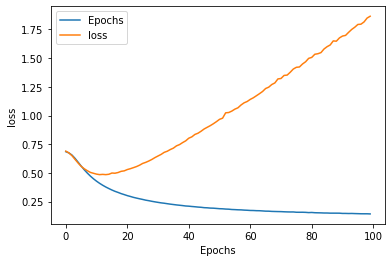

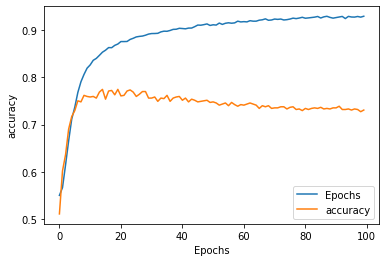

In [12]:
def plot_graph(hist, string):
    plt.plot(hist[string])
    plt.plot(hist['val_'+ string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(["Epochs", string])
    plt.show()
    
plot_graph(hist, 'loss')
plot_graph(hist, 'accuracy')

# Write a function to predict the sentiment of reviews

In [13]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]

In [14]:
def predict_review(model, reviews):
  # Create the sequences
    padding_type='post'
    sample_sequences = tokenizer.texts_to_sequences(reviews)
    reviews_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length) 
    classes = model.predict(reviews_padded)
    for x in range(len(reviews_padded)):
        print(reviews[x])
        print(classes[x])
        print('\n')

predict_review(model, new_reviews)

I loved this movie
[0.8349067]


that was the worst movie I've ever seen
[0.338825]


too much violence even for a Bond film
[2.6691492e-08]


a captivating recounting of a cherished myth
[0.99591744]




# Define a function to train and show the results of models with different layers

In [16]:
def fit_and_showResult(model, sentences):
    history = model.fit(padded_training,train_label_array, epochs = 100, validation_data=(padded_valid, valid_label_array))
    plot_graph(hist, 'accuracy')
    plot_graph(hist, 'loss')
    predict_review(model, sentences)

# Use a CNN

Epoch 1/100


C:\Users\Mustafa Hasnain\anaconda3\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


313/313 [==============================] - 2s 5ms/step - loss: 0.6582 - mae: 0.4774 - accuracy: 0.6084 - val_loss: 0.5880 - val_mae: 0.4331 - val_accuracy: 0.7339
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4491 - mae: 0.3231 - accuracy: 0.7999 - val_loss: 0.4731 - val_mae: 0.3113 - val_accuracy: 0.7798
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 0.3080 - mae: 0.2117 - accuracy: 0.8597 - val_loss: 0.4982 - val_mae: 0.2813 - val_accuracy: 0.7787
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.2426 - mae: 0.1655 - accuracy: 0.8878 - val_loss: 0.5586 - val_mae: 0.2766 - val_accuracy: 0.7615
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.2030 - mae: 0.1379 - accuracy: 0.9074 - val_loss: 0.6145 - val_mae: 0.2713 - val_accuracy: 0.7534
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 0.1747 - mae: 0.1189 - accuracy: 0.9169 - val_loss: 0.6713 - v

Epoch 48/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0601 - mae: 0.0422 - accuracy: 0.9583 - val_loss: 2.0500 - val_mae: 0.2835 - val_accuracy: 0.7202
Epoch 49/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0599 - mae: 0.0419 - accuracy: 0.9605 - val_loss: 2.0766 - val_mae: 0.2849 - val_accuracy: 0.7167
Epoch 50/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0593 - mae: 0.0418 - accuracy: 0.9608 - val_loss: 2.0825 - val_mae: 0.2848 - val_accuracy: 0.7167
Epoch 51/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0608 - mae: 0.0423 - accuracy: 0.9609 - val_loss: 2.0982 - val_mae: 0.2829 - val_accuracy: 0.7202
Epoch 52/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0594 - mae: 0.0416 - accuracy: 0.9598 - val_loss: 2.1216 - val_mae: 0.2822 - val_accuracy: 0.7271
Epoch 53/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0595 - mae: 0.0417 - accuracy: 0.9604 - va

313/313 [==============================] - 1s 3ms/step - loss: 0.0571 - mae: 0.0402 - accuracy: 0.9608 - val_loss: 2.5951 - val_mae: 0.2878 - val_accuracy: 0.7133
Epoch 95/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0565 - mae: 0.0399 - accuracy: 0.9619 - val_loss: 2.6116 - val_mae: 0.2835 - val_accuracy: 0.7202
Epoch 96/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0564 - mae: 0.0398 - accuracy: 0.9615 - val_loss: 2.6215 - val_mae: 0.2870 - val_accuracy: 0.7144
Epoch 97/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0571 - mae: 0.0401 - accuracy: 0.9610 - val_loss: 2.6049 - val_mae: 0.2846 - val_accuracy: 0.7190
Epoch 98/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0569 - mae: 0.0399 - accuracy: 0.9604 - val_loss: 2.5963 - val_mae: 0.2844 - val_accuracy: 0.7213
Epoch 99/100
313/313 [==============================] - 1s 3ms/step - loss: 0.0570 - mae: 0.0400 - accuracy: 0.9617 - val_loss: 2.614

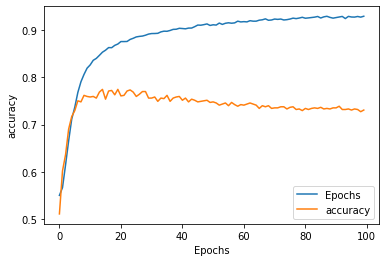

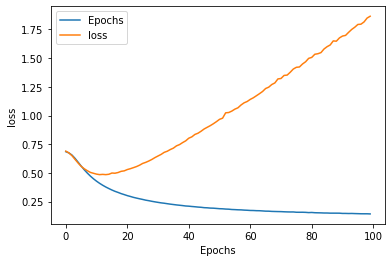

I loved this movie
[0.99998415]


that was the worst movie I've ever seen
[3.6152956e-11]


too much violence even for a Bond film
[3.9484004e-14]


a captivating recounting of a cherished myth
[1.]




In [23]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length))
model_cnn.add(tf.keras.layers.Conv1D(16, 5, activation = 'relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPool1D())
model_cnn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['mae', 'accuracy'])
fit_and_showResult(model_cnn, new_reviews)

Epoch 1/100


C:\Users\Mustafa Hasnain\anaconda3\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


313/313 [==============================] - 13s 28ms/step - loss: 0.6304 - mae: 0.4536 - accuracy: 0.6332 - val_loss: 0.5285 - val_mae: 0.3671 - val_accuracy: 0.7477
Epoch 2/100
313/313 [==============================] - 8s 25ms/step - loss: 0.4068 - mae: 0.2785 - accuracy: 0.8123 - val_loss: 0.5319 - val_mae: 0.3012 - val_accuracy: 0.7511
Epoch 3/100
313/313 [==============================] - 7s 24ms/step - loss: 0.3194 - mae: 0.2113 - accuracy: 0.8537 - val_loss: 0.5981 - val_mae: 0.2681 - val_accuracy: 0.7603
Epoch 4/100
313/313 [==============================] - 8s 25ms/step - loss: 0.2707 - mae: 0.1752 - accuracy: 0.8777 - val_loss: 0.6526 - val_mae: 0.2707 - val_accuracy: 0.7477
Epoch 5/100
313/313 [==============================] - 7s 24ms/step - loss: 0.2413 - mae: 0.1540 - accuracy: 0.8923 - val_loss: 0.7111 - val_mae: 0.2665 - val_accuracy: 0.7523
Epoch 6/100
313/313 [==============================] - 8s 25ms/step - loss: 0.2250 - mae: 0.1419 - accuracy: 0.8987 - val_loss: 0.7

313/313 [==============================] - 8s 25ms/step - loss: 0.0776 - mae: 0.0538 - accuracy: 0.9537 - val_loss: 2.2322 - val_mae: 0.2775 - val_accuracy: 0.7248
Epoch 48/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0825 - mae: 0.0544 - accuracy: 0.9517 - val_loss: 2.2857 - val_mae: 0.2864 - val_accuracy: 0.7202
Epoch 49/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0803 - mae: 0.0556 - accuracy: 0.9511 - val_loss: 2.2219 - val_mae: 0.2778 - val_accuracy: 0.7236
Epoch 50/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0790 - mae: 0.0531 - accuracy: 0.9526 - val_loss: 2.2229 - val_mae: 0.2705 - val_accuracy: 0.7351
Epoch 51/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0778 - mae: 0.0528 - accuracy: 0.9508 - val_loss: 2.1705 - val_mae: 0.2777 - val_accuracy: 0.7248
Epoch 52/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0756 - mae: 0.0523 - accuracy: 0.9535 - val_loss:

313/313 [==============================] - 8s 27ms/step - loss: 0.0647 - mae: 0.0453 - accuracy: 0.9568 - val_loss: 2.9157 - val_mae: 0.2757 - val_accuracy: 0.7236
Epoch 94/100
313/313 [==============================] - 8s 25ms/step - loss: 0.0751 - mae: 0.0487 - accuracy: 0.9554 - val_loss: 2.6177 - val_mae: 0.2737 - val_accuracy: 0.7305
Epoch 95/100
313/313 [==============================] - 8s 27ms/step - loss: 0.0695 - mae: 0.0477 - accuracy: 0.9556 - val_loss: 2.6195 - val_mae: 0.2764 - val_accuracy: 0.7236
Epoch 96/100
313/313 [==============================] - 9s 30ms/step - loss: 0.0667 - mae: 0.0467 - accuracy: 0.9571 - val_loss: 2.5159 - val_mae: 0.2844 - val_accuracy: 0.7190
Epoch 97/100
313/313 [==============================] - 8s 26ms/step - loss: 0.0641 - mae: 0.0456 - accuracy: 0.9578 - val_loss: 2.5690 - val_mae: 0.2747 - val_accuracy: 0.7294
Epoch 98/100
313/313 [==============================] - 8s 27ms/step - loss: 0.0643 - mae: 0.0453 - accuracy: 0.9557 - val_loss:

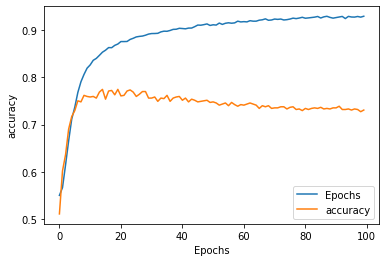

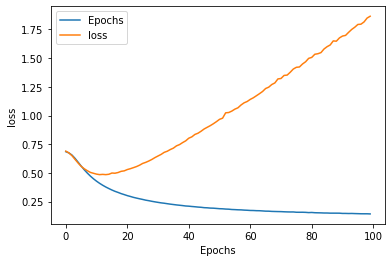

I loved this movie
[0.5898132]


that was the worst movie I've ever seen
[7.105778e-05]


too much violence even for a Bond film
[0.00110909]


a captivating recounting of a cherished myth
[0.99999547]




In [24]:
#Ading a Bidirectional LSTM Layer
model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length))
model_LSTM.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)))
model_LSTM.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['mae', 'accuracy'])
fit_and_showResult(model_LSTM, new_reviews)

In [ ]:
#Ading Multiple Bidirectional LSTM Layer
model_BI = tf.keras.Sequential()
model_BI.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length))
model_BI.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True)))
model_BI.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)))
model_BI.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
model_BI.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
fit_and_showResult(model_BI, new_reviews)